In [1]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
emc = float( sympy.S.EulerGamma.n(10) )

In [2]:
# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2,mu):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha

In [3]:
class prior:
    la = 0.5
    # Variances of the Gaussians in the mixture
    sigmas = [1]
    # Weights of the Gaussians in the mixture
    omegas = [1]
    def __init__(self, la, sigmas, omegas):
        self.la = la
        self.sigmas = sigmas
        self.omegas = omegas
    
def den_beta(r,gam1,prior): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))

    # How is this derived???
    # Is the sigma coming from the prior???
    # Note that gam1 * r / (gam1 + 1/sigma) = r / (1+1/(sigma*gam1)) = sigma * r / (sigma + 1/gam1)
    # This is equivalent to the formulation in the paper
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio



def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    # This is the negative of what is in the Overleaf. Still, this needs to be = 0 so *=-1 doesn't change the outcome
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    """
    Performs component-wise optimization of the parameters z_i
    We assume independence of parameters of z_i 
    """
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    # This is the second derivative of the expression g(z) to be maximized with the MAP estimation
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

In [4]:
### WEIBULL MODEL ###
def update_Weibull_alpha_eq(alpha, y, mu, z_hat, xi):
    n,_ = y.shape
    out = np.zeros(n)
    res = np.log(y) - mu - z_hat
    out = n / alpha + np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
    return out

def update_Weibull_alpha(y, mu, z_hat, alpha_old, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
    if isinstance(alpha_new, np.ndarray) or isinstance(alpha_new, list): alpha_new = float(alpha_new[0])
    return alpha_new

def update_Weibull_mu(y, z_hat, alpha, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    n,_ = y.shape
    mu_new = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))
    if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
    return mu_new

In [48]:
def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true, update_mu, update_alpha):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)
        if update_alpha:
            alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, predicted_xi)
            alphas.append(alpha_new)
            alpha = alpha_new
        if it > 5:
            if update_mu:
                mu_new = update_Weibull_mu(y, z1_hat, alpha, predicted_xi)
                mus.append(mu_new)
                mu = mu_new
        else:
            mus.append(mu)
        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
            


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats

In [36]:
def plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, p, correct_mu, correct_alpha, n, m):
    plt.figure(figsize=(20, 10))
    
    # Overall title
    plt.suptitle(f"Working with {n}x{m} matrix", fontsize=16)

    # Plotting corr_x
    plt.subplot(3, 4, 1)
    plt.ylabel('corr_x')
    plt.plot(range(len(corrs_x)), corrs_x, 'ro-')

    # Plotting l2_err_x
    plt.subplot(3, 4, 2)
    plt.ylabel('l2_err_x')
    plt.plot(range(len(l2_errs_x)), l2_errs_x, 'ro-')

    # Plotting corr_z
    plt.subplot(3, 4, 3)
    plt.ylabel('corr_z')
    plt.plot(range(len(corrs_z)), corrs_z, 'bo-')

    # Plotting l2_err_z
    plt.subplot(3, 4, 4)
    plt.ylabel('l2_err_z')
    plt.plot(range(len(l2_errs_z)), l2_errs_z, 'bo-')

    # Plotting mu evolution
    plt.subplot(3, 4, 5)
    plt.ylabel('mu')
    plt.plot(range(len(mus)), mus, 'go-')
    plt.axhline(y=correct_mu, color='r', linestyle='--', label='Correct mu')
    plt.legend()

    # Plotting alpha evolution
    plt.subplot(3, 4, 6)
    plt.ylabel('alpha')
    plt.plot(range(len(alphas)), alphas, 'go-')
    plt.axhline(y=correct_alpha, color='r', linestyle='--', label='Correct alpha')
    plt.legend()

    # Plotting Actual vs Predicted Scatter Plot in the last cell
    plt.subplot(3, 4, 7)
    indices = range(len(a))
    plt.scatter(indices, a, color='blue', label='Actual')
    plt.scatter(indices, p, color='red', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Scatter Plot')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make space for the suptitle
    plt.show()


gam1 =  105.68334641767389
tau1 =  0.1
alpha =  7.901950551639864
s.shape =  (100,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.06063125]
gam1 / (gam1 + 1/sigma) =  0.9906264657645354
alpha1 part I =  [0.06006292]
alpha2 part II =  [0.]
alpha1 =  0.060062922510747956
true gam2 =  2.5091984620684338
gam2 =  1653.8605119212605
corr(z1_hat, X*beta_true) =  0.15404629113492782
l2 error for z1_hat =  1.0848559686577213


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_21794/1719267712.py:56: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_21794/1719267712.py:45: RuntimeWarning: overflow encountered in exp
  res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)


v1 =  0.04187072286059941
true tau2 =  54.814615017481024
tau2 = 2.288303644361024
->LMMSE
corr(x2_hat, beta_true) =  [[0.07359956]]
l2 error for x2_hat =  0.9998365072263266
alpha2 =  0.9985294741756635
true gam1 =  4.355055573059998
gam1 =  2.435626243920695
corr(z2_hat, beta_true) =  [[-0.71650344]]
l2 error for z2_hat =  1.0121781197087756
true tau1 =  37.96529511020281
tau1 =  12446.611846169862


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.32349026]
corr(x1_hat, beta_true) =  0.21273957209984526
l2 error for x1_hat =  1.028480774593132
B / (A+B) =  [0.42172274]
gam1 / (gam1 + 1/sigma) =  0.7089322501917985
alpha1 part I =  [0.29897285]
alpha2 part II =  [0.2444167]
alpha1 =  0.5966022732226339
true gam2 =  2.56892902698017
gam2 =  1.6468695044851998
corr(z1_hat, X*beta_true) =  -0.715656032966765
l2 error for z1_hat =  1.0119809315410144
v1 =  0.9998809131412285
true tau2 =  45.0436475269667
tau2 = 1.4824044419967968
->LMMSE
corr(x2_hat, beta_true) =  [[0.77657281]]
l

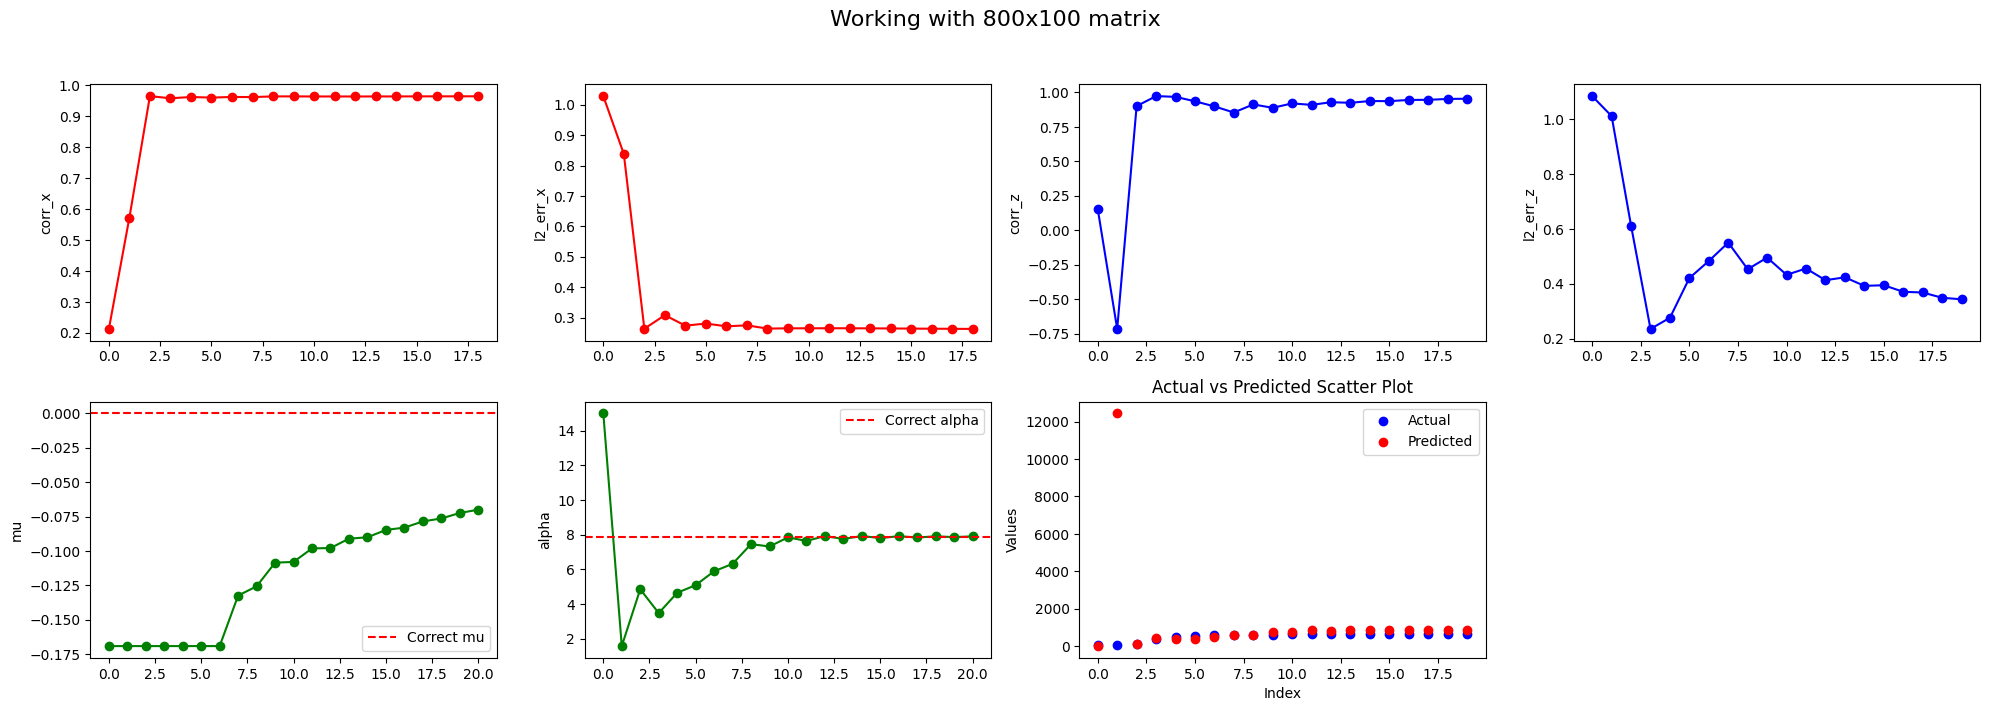

In [51]:
np.random.seed(42)
n=800
m=100

X,beta,y,alpha = sim_model(n=n,m=m,p=p,la=la,sigma=sigma,h2=h2,mu=mu )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

pr = prior(la = la, sigmas = [sigma], omegas = [omega])

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])


est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha*1.9, np.mean(np.log(y)), maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

gam1 =  26.213476215710013
tau1 =  0.1
alpha =  5.572760024264562
s.shape =  (200,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.1133147]
gam1 / (gam1 + 1/sigma) =  0.9632535001381884
alpha1 part I =  [0.10915078]
alpha2 part II =  [0.]
alpha1 =  0.10915077813041439
true gam2 =  2.237374591527024
gam2 =  213.94492361163617


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_21794/1719267712.py:56: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_21794/1719267712.py:45: RuntimeWarning: overflow encountered in exp
  res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)


corr(z1_hat, X*beta_true) =  0.6174646153289942
l2 error for z1_hat =  0.7908569251812085
v1 =  0.05595858047391448
true tau2 =  28.215114736127475
tau2 = 1.6870360390327588
->LMMSE
corr(x2_hat, beta_true) =  [[0.29363526]]
l2 error for x2_hat =  0.9969947693449963
alpha2 =  0.9937390549798772
true gam1 =  4.446514412494023
gam1 =  1.347936762024454
corr(z2_hat, beta_true) =  [[0.83092359]]
l2 error for z2_hat =  0.9225115867389543
true tau1 =  18.991463403759045
tau1 =  1076.1285548090607


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.3634232]
corr(x1_hat, beta_true) =  0.44750034705406916
l2 error for x1_hat =  0.8942838467060602
B / (A+B) =  [0.34927355]
gam1 / (gam1 + 1/sigma) =  0.5740941510120685
alpha1 part I =  [0.2005159]
alpha2 part II =  [0.05480194]
alpha1 =  0.36804124894577783
true gam2 =  2.5142284852027776
gam2 =  2.314524350379391
corr(z1_hat, X*beta_true) =  0.8315981642618865
l2 error for z1_hat =  0.9235828515527165
v1 =  0.9989869319143384
true tau2 =  1

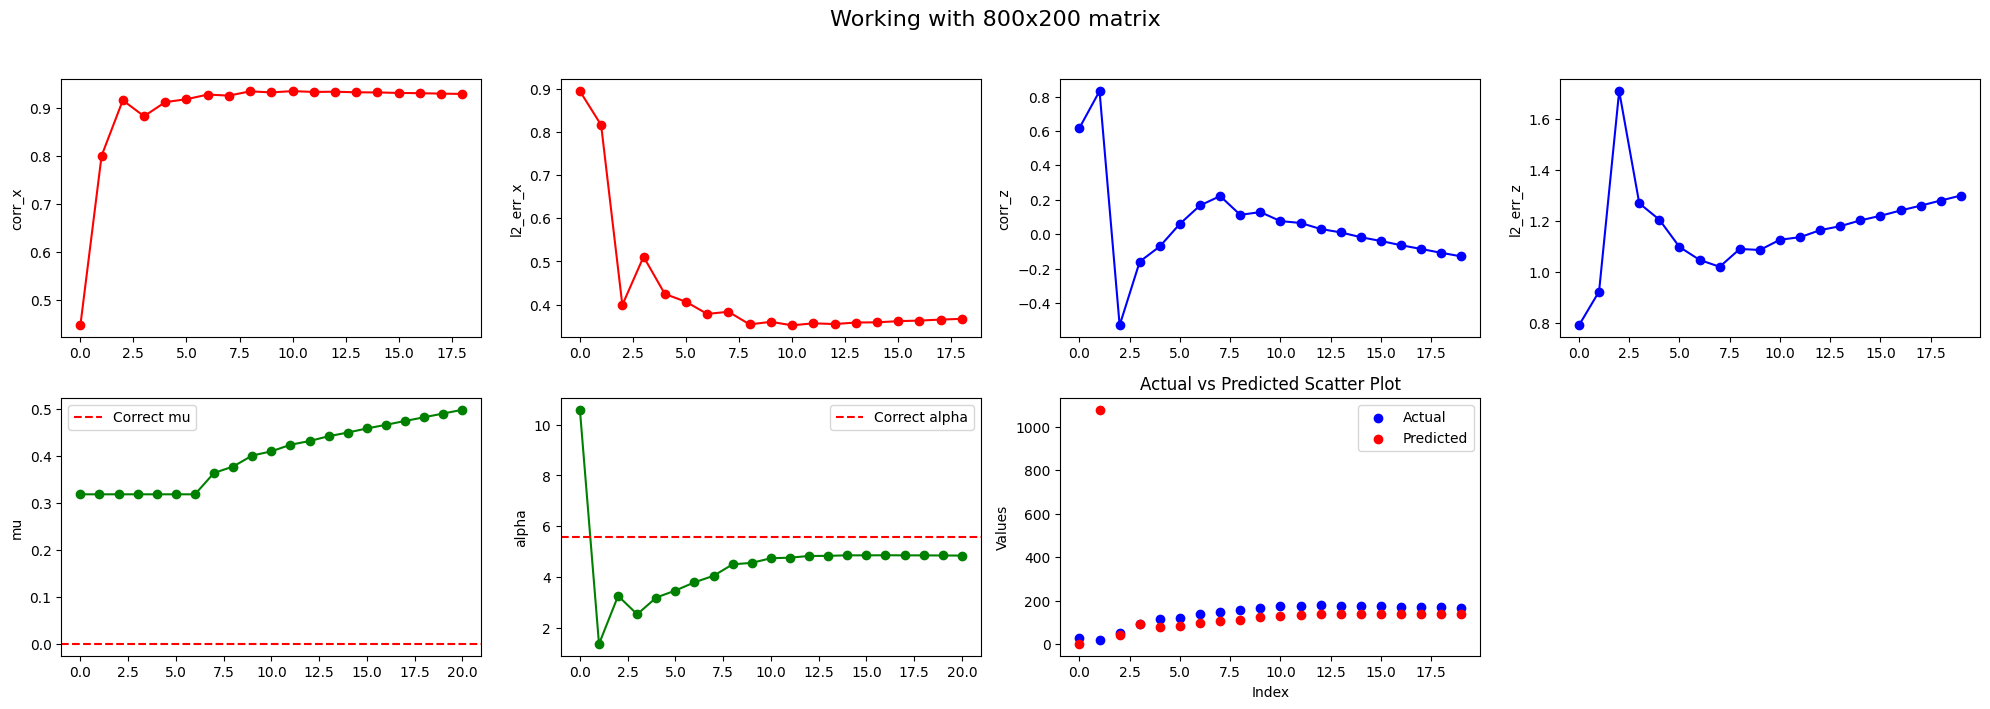

In [52]:
np.random.seed(42)
n=800
m=200

X,beta,y,alpha = sim_model(n=n,m=m,p=p,la=la,sigma=sigma,h2=h2,mu=mu )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

pr = prior(la = la, sigmas = [sigma], omegas = [omega])

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])


est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha*1.9, np.mean(np.log(y)), maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Algorithm is stable if we fix mu to be empirical average of Log(Y)

gam1 =  8.617681541932713
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.17693296]
gam1 / (gam1 + 1/sigma) =  0.8960248376243236
alpha1 part I =  [0.15853633]
alpha2 part II =  [0.]
alpha1 =  0.15853633037267234
true gam2 =  2.3722202522924425
gam2 =  45.74008946030428


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_21794/1719267712.py:56: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6653817265593969
l2 error for z1_hat =  0.7622697816693841
v1 =  0.09045618852626258
true tau2 =  7.444334544210657
tau2 = 1.0055075570751748
->LMMSE
corr(x2_hat, beta_true) =  [[0.41401544]]
l2 error for x2_hat =  0.9943909815067091
alpha2 =  0.9885472654100349
true gam1 =  2.5708706368906644
gam1 =  0.5299181162499498
corr(z2_hat, beta_true) =  [[0.41108045]]
l2 error for z2_hat =  0.9234718100243745
true tau1 =  5.290740903769899
tau1 =  86.79077805284388


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.03558518]
corr(x1_hat, beta_true) =  0.43071553382918537
l2 error for x1_hat =  0.9413602144857075
B / (A+B) =  [0.40685433]
gam1 / (gam1 + 1/sigma) =  0.34637024728411975
alpha1 part I =  [0.14092224]
alpha2 part II =  [0.04030375]
alpha1 =  0.13492306329013656
true gam2 =  2.3893320642350897
gam2 =  3.397639584618594
corr(z1_hat, X*beta_true) =  0.41634463346360234
l2 error for z1_hat =  0.9237545873499596
v1 =  0.9925170077192734
true tau2 

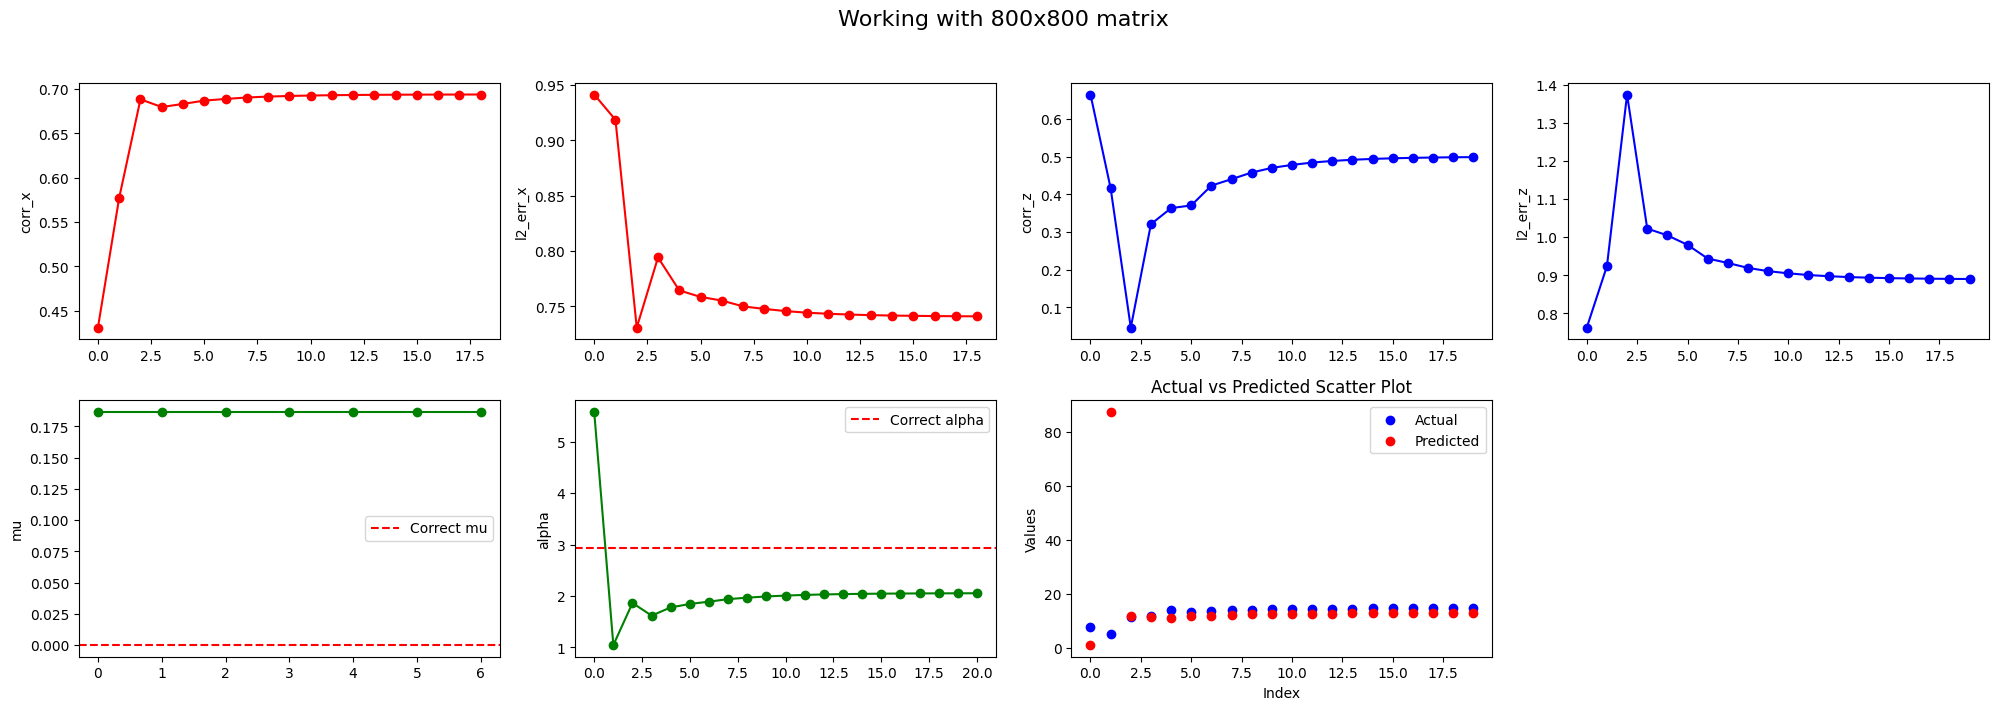

In [55]:
np.random.seed(42)
n=800
m=800

X,beta,y,alpha = sim_model(n=n,m=m,p=p,la=la,sigma=sigma,h2=h2,mu=mu )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

pr = prior(la = la, sigmas = [sigma], omegas = [omega])

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])


est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha*1.9, np.mean(np.log(y)), maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)